This notebook serves as the Deep Bayesian Active Learning paper implementation based on:
- https://github.com/damienlancry/DBAL/blob/master/dbal_pytorch.ipynb
- https://github.com/wohlert/semi-supervised-pytorch/blob/master/examples/notebooks/Deep%20Generative%20Model.ipynb

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Set number of initial labelled data per class
INITIAL_LABEL_PER_CLASS = 10
N_LABELS = 10 #MNIST

In [2]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner
from torchsummary import summary
import pickle

import pandas as pd
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import sys

In [3]:
!pip freeze | grep pandas

pandas==1.4.3


In [4]:
# Use cuda if available
cuda = torch.cuda.is_available()
# Add a semi supervised module
sys.path.insert(0, './semi-supervised')

In [5]:
def set_seed(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [6]:
set_seed(111)

### Network Architecture

In [7]:
train = CIFAR10('.', train=True, download=True, transform=ToTensor())
test = CIFAR10('.', train=False, download=True, transform=ToTensor())
# train_data_loader = DataLoader(train, shuffle = True, batch_size = 60_000)
train_data_loader = DataLoader(train, shuffle = True, batch_size = 50_000)
test_data_loader = DataLoader(test, shuffle = True, batch_size = 10_000)
X_train, y_train = next(iter(train_data_loader))
X_train = X_train.detach().cpu().numpy()
y_train = y_train.detach().cpu().numpy()

X_test, y_test = next(iter(test_data_loader))
X_test = X_test.detach().cpu().numpy()
y_test = y_test.detach().cpu().numpy()


Files already downloaded and verified
Files already downloaded and verified


In [8]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.convs = nn.Sequential(
                        # nn.Conv2d(1, 32, 4),
                        nn.Conv2d(3, 32, 4),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, 4),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Dropout(0.25),
                        nn.Flatten(),
                        # nn.Linear(11*11*32, 128),
                        nn.Linear(13*13*32, 128),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(128, 10)
                    )

    def forward(self, x):
        if len(x.shape) != 2:
            out = x
            out = self.convs(out)
        else:
            out = x.reshape(-1, 1, 28, 28)
            out = self.convs(out)
            out = F.softmax(out, dim=-1)
        return out

In [9]:
summary(CNN().convs, (3,32,32), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 29, 29]           1,568
              ReLU-2           [-1, 32, 29, 29]               0
            Conv2d-3           [-1, 32, 26, 26]          16,416
              ReLU-4           [-1, 32, 26, 26]               0
         MaxPool2d-5           [-1, 32, 13, 13]               0
           Dropout-6           [-1, 32, 13, 13]               0
           Flatten-7                 [-1, 5408]               0
            Linear-8                  [-1, 128]         692,352
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 711,626
Trainable params: 711,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## Preprocessing

In [10]:
# X_train = X_train.reshape(60_000, 1, 28, 28)
# X_test = X_test.reshape(10_000, 1, 28, 28)
X_train = X_train.reshape(50_000, 3, 32, 32)
X_test = X_test.reshape(10_000, 3, 32, 32)

In [11]:
# Create initial labelled data
# Take INITIAL_LABELLED_PER_CLASS samples from each digit
initial_labelled_idx = np.array([],dtype=np.int64)
for i in range(N_LABELS):
    idx = np.random.choice(np.where(y_train==i)[0], size=INITIAL_LABEL_PER_CLASS, replace=False)
    initial_labelled_idx = np.concatenate((initial_labelled_idx, idx))

X_train_labelled_initial = X_train[initial_labelled_idx]
y_train_labelled_initial = y_train[initial_labelled_idx]

In [12]:
# Create a pool of unlabelled data
X_train_unlabelled = np.delete(X_train, initial_labelled_idx, axis = 0)
y_train_unlabelled = np.delete(y_train, initial_labelled_idx, axis = 0)

### Query Strategies

#### Random (Uniform)

In [13]:
def uniform(learner, X, n_instances = 1):
    query_idx = np.random.choice(range(len(X)), size = n_instances, replace = False)
    return query_idx, X[query_idx]

#### Max Entropy

Formula:

$$\mathbb{H} = -\sum_{c}p_clog(p_c)$$

Where $p_c$ is the probability of the instance being in the class $c$ and is approximated by:

$$p_c = \dfrac{1}{T}\sum_{c}p_c^{(t)}$$

Where $p_c^{(t)}$ is the probability of the instance being in the class $c$ at t-th forward pass

In [14]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    acquisition = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

#### Bald

In [15]:
def bald(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]    


### Active Learning 

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

query_strategies = {
    'random':{'function':uniform,
                                'classifier': None,
                                'learner': None,
                                'performance_history': None},
                    # 'max_entropy':{'function':max_entropy,
                    #             'classifier': None,
                    #             'learner': None,
                    #             'performance_history': None},
                    'bald':{'function':bald,
                                'classifier': None,
                                'learner': None,
                                'performance_history': None},
                    }

In [17]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=10,
                              # n_queries=10,
                              n_instances=10,
                              query_strategy_label=''):
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy,
                           )
    perf_hist = [learner.score(X_test, y_test)]
    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('{q}Accuracy after query {n}: {acc:0.4f}'.format(q=f'[{query_strategy_label}] ', n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)

    # Save after-query labelled and unlabelled data
    print(learner.X_training.reshape(-1, 3*32*32).shape)
    torch.save(learner.X_training.reshape(-1, 3*32*32), f'./saved_data/X_train_labelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
    
    print(learner.y_training.shape)
    torch.save(learner.y_training, f'./saved_data/y_train_labelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
    
    print(X_pool.reshape(-1, 3*32*32).shape)
    torch.save(X_pool.reshape(-1, 3*32*32), f'./saved_data/X_train_unlabelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
    
    print(y_pool.shape)
    torch.save(y_pool, f'./saved_data/y_train_unlabelled_{query_strategy_label}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')

    return learner, perf_hist

In [18]:
for query_strategy_name, query_strategy in query_strategies.items():
    query_strategy['classifier'] = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
    query_strategy['learner'], query_strategy['performance_history'] = active_learning_procedure(query_strategy['function'],
                                                X_test,
                                                y_test,
                                                X_train_unlabelled,
                                                y_train_unlabelled,
                                                X_train_labelled_initial,
                                                y_train_labelled_initial,
                                                query_strategy['classifier'],
                                                query_strategy_label=query_strategy_name)

[random] Accuracy after query 1: 0.2392
[random] Accuracy after query 2: 0.2408
[random] Accuracy after query 3: 0.2459
[random] Accuracy after query 4: 0.2416
[random] Accuracy after query 5: 0.2473
[random] Accuracy after query 6: 0.2538
[random] Accuracy after query 7: 0.2614
[random] Accuracy after query 8: 0.2583
[random] Accuracy after query 9: 0.2697


: 

: 

In [ ]:
# Save models and data
performance_histories = {}
for query_strategy_name, query_strategy in query_strategies.items():
    # Save classifiers
    query_strategy['classifier'].save_params(f_params=f'./saved_models/{query_strategy_name}_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pkl')

    # Save data after queries:
    # torch.save(query_strategy['learner'].X_training, f'./saved_data/X_training_{query_strategy_name}.pt')
    # torch.save(query_strategy['learner'].y_training, f'./saved_data/y_training_{query_strategy_name}.pt')

# Save initial labelled and unlabelled data
X_train_labelled_initial = X_train[initial_labelled_idx]
y_train_labelled_initial = y_train[initial_labelled_idx]
torch.save(X_train_labelled_initial, f'./saved_data/X_train_labelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
torch.save(y_train_labelled_initial, f'./saved_data/y_train_labelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
torch.save(X_train_unlabelled, f'./saved_data/X_train_unlabelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')
torch.save(y_train_unlabelled, f'./saved_data/y_train_unlabelled_{N_LABELS*INITIAL_LABEL_PER_CLASS}.pt')

# Save test data
torch.save(X_test, f'./saved_data/X_test.pt')
torch.save(y_test, f'./saved_data/y_test.pt')

# Save performance histories (preprocessing)
performance_histories = {query_strategy_name: query_strategy['performance_history'] for query_strategy_name, query_strategy in query_strategies.items()}
pd.DataFrame(performance_histories).to_csv(f'./saved_data/active_learning_performance_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')


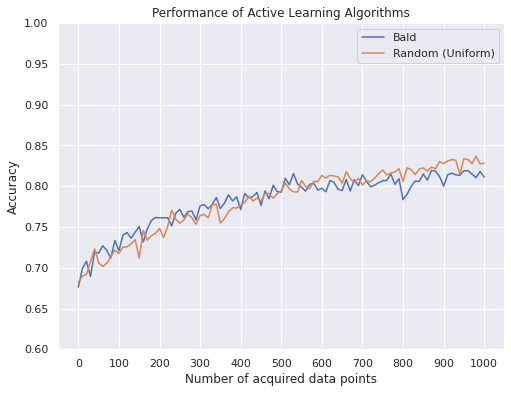

In [ ]:
# Plot
sns.set()
# plt.plot(query_strategies['max_entropy']['performance_history'], label="max entropy")
fig, ax = plt.subplots(figsize=(8, 6))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001, 100)
ax.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001, 10)
ax.plot(x_ticks, query_strategies['bald']['performance_history'], label="Bald")
ax.plot(x_ticks, query_strategies['random']['performance_history'], label="Random (Uniform)")
ax.set_ylim([0.6,1])

ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of acquired data points")
ax.set_title("Performance of Active Learning Algorithms")
ax.legend()


###  Semi-supervised Learning

<img src="./images/dgm.png" width="400px"/>

In [18]:
from models import DeepGenerativeModel
from datautils import get_mnist
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler
from torch.autograd import Variable

SSL_EPOCHS = 100

def binary_cross_entropy(y_pred, y):
    return -torch.sum(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8), dim=-1)


x_dim = 784
y_dim = 10
z_dim = 32
h_dim = [256, 128]

SSL_metrics = {'random':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    # 'max_entropy':{'function':max_entropy,
                    #             'classifier': None,
                    #             'learner': None,
                    #             'performance_history': None},
                    'bald':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    }


In [19]:
def calculate_J_alpha(x, y, u, alpha, model):
    # Calculate ELBOs
    L = -elbo(x, y)
    U = -elbo(u)

    # Add auxiliary classification loss q(y|x)
    logits = model.classify(x)
    
    # Regular cross entropy
    classification_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

    J_alpha = L + alpha * classification_loss + U

    return J_alpha, logits

In [20]:
from torch.autograd import Variable

for algorithm in SSL_metrics.keys():
    # Only use INITIAL_LABEL_PER_CLASS labelled examples per class
    # The rest of the data is unlabelled.
    labelled, unlabelled, test = get_mnist(location="./saved_data", batch_size=64, labels_per_class=INITIAL_LABEL_PER_CLASS, algorithm=algorithm)

    # Prepare the model and the optimizer
    model = DeepGenerativeModel([x_dim, y_dim, z_dim, h_dim])

    del model.classifier
    model.classifier = query_strategies[algorithm]['classifier']
    if cuda: model = model.cuda()
    alpha = 0.1 * len(unlabelled) / len(labelled)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

    # Prepare a sampler and the elbo object
    # You can use importance weighted samples [Burda, 2015] to get a better estimate
    # on the log-likelihood.
    sampler = ImportanceWeightedSampler(mc=1, iw=1)
    elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)


    SSL_train_loss_history = []
    SSL_train_accuracy_history = []
    SSL_test_loss_history = []
    SSL_test_accuracy_history = []

    for epoch in range(SSL_EPOCHS):
        model.train()
        total_loss, accuracy = (0, 0)
        for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
            # Wrap in variables
            x, y, u = Variable(x).cuda(device=0), Variable(y).cuda(device=0), Variable(u).cuda(device=0)

            J_alpha, logits = calculate_J_alpha(x.reshape(-1, 784), y, u, alpha, model)

            J_alpha.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += J_alpha.data
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
            
        if epoch % 1 == 0:
            model.eval()
            m = len(unlabelled)

            train_loss = total_loss/m
            train_accuracy = accuracy/m

            SSL_train_loss_history.append(train_loss)
            SSL_train_accuracy_history.append(train_accuracy)
            print("Epoch: {}".format(epoch))
            print("[Train]\t J_a: {:.2f}, accuracy: {:.2f}".format(train_loss, train_accuracy))

            total_loss, accuracy = (0, 0)
            for x, y in test:
                x, y = Variable(x).cuda(device=0), Variable(y).cuda(device=0)

                J_alpha, logits = calculate_J_alpha(x.reshape(-1, 784), y, x.reshape(-1, 784), alpha, model)

                total_loss += J_alpha.data

                _, pred_idx = torch.max(logits, 1)
                _, lab_idx = torch.max(y, 1)
                accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

            m = len(test)

            test_loss = total_loss/m
            test_accuracy = accuracy/m

            SSL_test_loss_history.append(test_loss)
            SSL_test_accuracy_history.append(test_accuracy)

            print("[Test]\t J_a: {:.2f}, accuracy: {:.2f}".format(test_loss, test_accuracy))

    SSL_metrics[algorithm]['train_loss_history'] = [x.item() for x in SSL_train_loss_history]
    SSL_metrics[algorithm]['train_accuracy_history'] = [x.item() for x in SSL_train_accuracy_history]
    SSL_metrics[algorithm]['test_loss_history'] = [x.item() for x in SSL_test_loss_history]
    SSL_metrics[algorithm]['test_accuracy_history'] = [x.item() for x in SSL_test_accuracy_history]

./saved_data/X_train_labelled_random_100.pt
./saved_data/y_train_labelled_random_100.pt
1100 1100
./saved_data/X_train_unlabelled_random_100.pt
./saved_data/y_train_unlabelled_random_100.pt
58900 58900
./saved_data/X_test.pt
./saved_data/y_test.pt
10000 10000


/root/ucl/dissertation/./semi-supervised/models/vae.py:114: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


Epoch: 0
[Train]	 J_a: 383.45, accuracy: 1.00
[Test]	 J_a: 318.82, accuracy: 0.96
Epoch: 1
[Train]	 J_a: 305.47, accuracy: 1.00
[Test]	 J_a: 298.15, accuracy: 0.96
Epoch: 2
[Train]	 J_a: 290.13, accuracy: 1.00
[Test]	 J_a: 288.48, accuracy: 0.96
Epoch: 3
[Train]	 J_a: 282.67, accuracy: 1.00
[Test]	 J_a: 283.41, accuracy: 0.96
Epoch: 4
[Train]	 J_a: 277.09, accuracy: 1.00
[Test]	 J_a: 279.43, accuracy: 0.96
Epoch: 5
[Train]	 J_a: 271.95, accuracy: 1.00
[Test]	 J_a: 276.53, accuracy: 0.96
Epoch: 6
[Train]	 J_a: 269.98, accuracy: 1.00
[Test]	 J_a: 274.97, accuracy: 0.96
Epoch: 7
[Train]	 J_a: 267.24, accuracy: 1.00
[Test]	 J_a: 273.49, accuracy: 0.96
Epoch: 8
[Train]	 J_a: 264.72, accuracy: 1.00
[Test]	 J_a: 271.83, accuracy: 0.96
Epoch: 9
[Train]	 J_a: 263.43, accuracy: 1.00
[Test]	 J_a: 271.09, accuracy: 0.96
Epoch: 10
[Train]	 J_a: 261.93, accuracy: 1.00
[Test]	 J_a: 269.87, accuracy: 0.96
Epoch: 11
[Train]	 J_a: 260.31, accuracy: 1.00
[Test]	 J_a: 269.58, accuracy: 0.96
Epoch: 12
[Tra

In [23]:
# Save performance histories
# Test
SSL_test_loss_histories = {f'{algorithm}_test_loss': val['test_loss_history'] for algorithm, val in SSL_metrics.items()}
SSL_test_accuracy_histories = {f'{algorithm}_test_accuracy': val['test_accuracy_history'] for algorithm, val in SSL_metrics.items()}
# Train
SSL_train_loss_histories = {f'{algorithm}_train_loss': val['train_loss_history'] for algorithm, val in SSL_metrics.items()}
SSL_train_accuracy_histories = {f'{algorithm}_train_accuracy': val['train_accuracy_history'] for algorithm, val in SSL_metrics.items()}

# Save process
pd.DataFrame(SSL_test_loss_histories).to_csv(f'./saved_data/SSL_test_loss_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')
pd.DataFrame(SSL_test_accuracy_histories).to_csv(f'./saved_data/SSL_test_accuracy_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')
pd.DataFrame(SSL_train_loss_histories).to_csv(f'./saved_data/SSL_train_loss_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')
pd.DataFrame(SSL_train_accuracy_histories).to_csv(f'./saved_data/SSL_train_accuracy_histories_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')

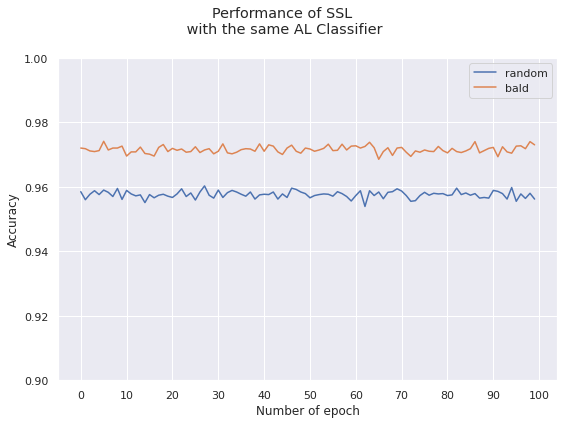

In [26]:
# Plot the SSL Performance
# Plot
sns.set()


# fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
#                                     figsize=(16, 8))
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(8, 6))


# Set y axis format
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, SSL_EPOCHS+1,10)
ax0.set_xticks(major_ticks)

x_ticks = np.arange(0, SSL_EPOCHS,1)
ax0.plot(x_ticks, SSL_test_accuracy_histories['random_test_accuracy'], label = 'random')
ax0.plot(x_ticks, SSL_test_accuracy_histories['bald_test_accuracy'], label = 'bald')
ax0.set_ylim([0.9,1])
ax0.set_ylabel("Accuracy")
ax0.set_xlabel("Number of epoch")
ax0.legend()

# # Set y axis format
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# # Major ticks every 20, minor ticks every 5
# major_ticks = np.arange(0, SSL_EPOCHS+1,10)
# ax1.set_xticks(major_ticks)

# x_ticks = np.arange(0, SSL_EPOCHS,1)
# ax1.plot(x_ticks, SSL_test_loss_histories['random_test_loss'], label = 'random')
# ax1.plot(x_ticks, SSL_test_loss_histories['bald_test_loss'], label = 'bald')
# # ax1.set_ylim([0.8,1])
# ax1.set_ylabel("Test Loss")
# ax1.set_xlabel("Number of epoch")
# ax1.legend()

fig.suptitle("Performance of SSL\n with the same AL Classifier")
plt.tight_layout()


## Progressive Setting

In [8]:
from models import DeepGenerativeModel
from datautils import get_mnist
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler
from torch.autograd import Variable

SSL_EPOCHS = 50

def binary_cross_entropy(y_pred, y):
    return -torch.sum(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8), dim=-1)


x_dim = 784
y_dim = 10
z_dim = 32
h_dim = [256, 128]

SSL_metrics = {'random':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    # 'max_entropy':{'function':max_entropy,
                    #             'classifier': None,
                    #             'learner': None,
                    #             'performance_history': None},
                    'bald':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    }

In [9]:
def calculate_J_alpha(x, y, u, alpha, model):
    # Calculate ELBOs
    L = -elbo(x, y)
    U = -elbo(u)

    # Add auxiliary classification loss q(y|x)
    logits = model.classify(x)
    
    # Regular cross entropy
    classification_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

    J_alpha = L + alpha * classification_loss + U

    return J_alpha, logits

In [10]:
from torch.autograd import Variable


SSL_progressive_performance = {'random':[],
                                'bald':[]}

for cap in range(100,1101,100):
    SSL_metrics = {'random':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    # 'max_entropy':{'function':max_entropy,
                    #             'classifier': None,
                    #             'learner': None,
                    #             'performance_history': None},
                    'bald':{'train_loss_history':None,
                                'train_accuracy_history': None,
                                'test_loss_history': None,
                                'test_accuracy_history': None},
                    }
    for algorithm in SSL_metrics.keys():
        
        # Only use INITIAL_LABEL_PER_CLASS labelled examples per class
        # The rest of the data is unlabelled.
        labelled, unlabelled, test = get_mnist(location="./saved_data", batch_size=64, labels_per_class=INITIAL_LABEL_PER_CLASS, algorithm=algorithm, data_size_cap=cap)

        # Prepare the model and the optimizer
        model = DeepGenerativeModel([x_dim, y_dim, z_dim, h_dim])

        if cuda: model = model.cuda()
        alpha = 0.1 * len(unlabelled) / len(labelled)
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

        # Prepare a sampler and the elbo object
        # You can use importance weighted samples [Burda, 2015] to get a better estimate
        # on the log-likelihood.
        sampler = ImportanceWeightedSampler(mc=1, iw=1)
        elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)


        SSL_train_loss_history = []
        SSL_train_accuracy_history = []
        SSL_test_loss_history = []
        SSL_test_accuracy_history = []

        for epoch in range(SSL_EPOCHS):
            model.train()
            total_loss, accuracy = (0, 0)
            for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
                # Wrap in variables
                x, y, u = Variable(x).cuda(device=0), Variable(y).cuda(device=0), Variable(u).cuda(device=0)

                J_alpha, logits = calculate_J_alpha(x.reshape(-1, 784), y, u, alpha, model)

                J_alpha.backward()
                optimizer.step()
                optimizer.zero_grad()

                total_loss += J_alpha.data
                accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
                
            if epoch % 1 == 0:
                model.eval()
                m = len(unlabelled)

                train_loss = total_loss/m
                train_accuracy = accuracy/m

                SSL_train_loss_history.append(train_loss)
                SSL_train_accuracy_history.append(train_accuracy)
                print("Epoch: {}".format(epoch))
                print("[Train]\t J_a: {:.2f}, accuracy: {:.2f}".format(train_loss, train_accuracy))

                total_loss, accuracy = (0, 0)
                for x, y in test:
                    x, y = Variable(x).cuda(device=0), Variable(y).cuda(device=0)

                    J_alpha, logits = calculate_J_alpha(x.reshape(-1, 784), y, x.reshape(-1, 784), alpha, model)

                    total_loss += J_alpha.data

                    _, pred_idx = torch.max(logits, 1)
                    _, lab_idx = torch.max(y, 1)
                    accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

                m = len(test)

                test_loss = total_loss/m
                test_accuracy = accuracy/m

                SSL_test_loss_history.append(test_loss)
                SSL_test_accuracy_history.append(test_accuracy)

                print("[Test]\t J_a: {:.2f}, accuracy: {:.4f}".format(test_loss, test_accuracy))

        SSL_metrics[algorithm]['train_loss_history'] = [x.item() for x in SSL_train_loss_history]
        SSL_metrics[algorithm]['train_accuracy_history'] = [x.item() for x in SSL_train_accuracy_history]
        SSL_metrics[algorithm]['test_loss_history'] = [x.item() for x in SSL_test_loss_history]
        SSL_metrics[algorithm]['test_accuracy_history'] = [x.item() for x in SSL_test_accuracy_history]
        
        SSL_progressive_performance[algorithm].append(SSL_metrics[algorithm]['test_accuracy_history'][-1])

./saved_data/X_train_labelled_random_100_base.pt
./saved_data/y_train_labelled_random_100_base.pt
100 100
./saved_data/X_train_unlabelled_random_100_base.pt
./saved_data/y_train_unlabelled_random_100_base.pt
59900 59900
./saved_data/X_test_base.pt
./saved_data/y_test_base.pt
10000 10000


/root/ucl/dissertation/./semi-supervised/models/vae.py:114: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


Epoch: 0
[Train]	 J_a: 366.46, accuracy: 0.96
[Test]	 J_a: 354.28, accuracy: 0.8271
Epoch: 1
[Train]	 J_a: 269.82, accuracy: 1.00
[Test]	 J_a: 347.56, accuracy: 0.8364
Epoch: 2
[Train]	 J_a: 250.07, accuracy: 1.00
[Test]	 J_a: 342.90, accuracy: 0.8596
Epoch: 3
[Train]	 J_a: 235.11, accuracy: 1.00
[Test]	 J_a: 335.59, accuracy: 0.8707
Epoch: 4
[Train]	 J_a: 226.19, accuracy: 1.00
[Test]	 J_a: 330.51, accuracy: 0.8809
Epoch: 5
[Train]	 J_a: 219.41, accuracy: 1.00
[Test]	 J_a: 329.99, accuracy: 0.8820
Epoch: 6
[Train]	 J_a: 215.03, accuracy: 1.00
[Test]	 J_a: 331.97, accuracy: 0.8859
Epoch: 7
[Train]	 J_a: 211.18, accuracy: 1.00
[Test]	 J_a: 327.34, accuracy: 0.8946
Epoch: 8
[Train]	 J_a: 207.78, accuracy: 1.00
[Test]	 J_a: 329.49, accuracy: 0.9018
Epoch: 9
[Train]	 J_a: 204.40, accuracy: 1.00
[Test]	 J_a: 322.94, accuracy: 0.9065
Epoch: 10
[Train]	 J_a: 201.86, accuracy: 1.00
[Test]	 J_a: 322.84, accuracy: 0.9081
Epoch: 11
[Train]	 J_a: 199.67, accuracy: 1.00
[Test]	 J_a: 324.91, accurac

In [11]:
pd.DataFrame(SSL_progressive_performance).to_csv(f'./saved_data/SSL_progressive_performance_{N_LABELS*INITIAL_LABEL_PER_CLASS}.csv')

## Performance Plot

In [5]:
SSL_perf_df = pd.read_csv('./saved_data/SSL_progressive_performance_100.csv')
AL_perf_df = pd.read_csv('./saved_data/active_learning_performance_histories_100_base.csv').loc[range(0,101, 10)]

In [6]:
SSL_perf_df['bald']

0     0.927946
1     0.962182
2     0.968551
3     0.972034
4     0.977309
5     0.978802
6     0.979598
7     0.982086
8     0.979996
9     0.982882
10    0.983678
Name: bald, dtype: float64

In [7]:
SSL_perf_df['random']

0     0.930135
1     0.949244
2     0.961186
3     0.963873
4     0.964371
5     0.966859
6     0.969447
7     0.971039
8     0.968750
9     0.972333
10    0.972731
Name: random, dtype: float64

In [8]:
AL_perf_df['random']

0      0.8066
10     0.8531
20     0.8939
30     0.9146
40     0.9273
50     0.9290
60     0.9441
70     0.9502
80     0.9568
90     0.9616
100    0.9648
Name: random, dtype: float64

In [9]:
AL_perf_df['bald']

0      0.8028
10     0.8793
20     0.9191
30     0.9596
40     0.9642
50     0.9697
60     0.9712
70     0.9757
80     0.9764
90     0.9784
100    0.9802
Name: bald, dtype: float64

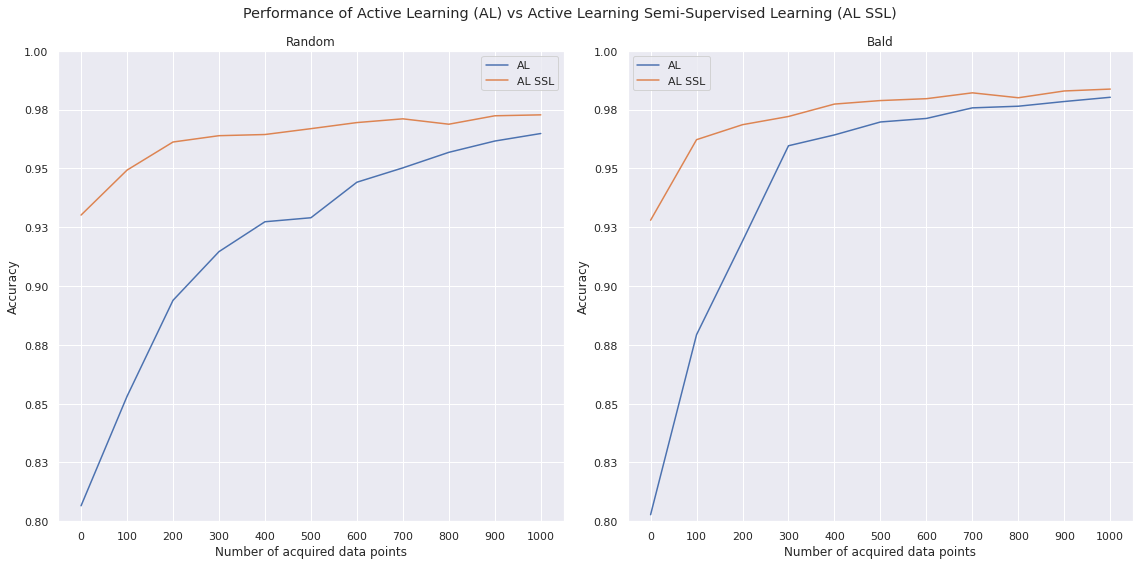

In [12]:
# Plot the SSL-AL Performance
# Plot
sns.set()


fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(16, 8))

# Set y axis format
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001,100)
ax0.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001,100)
ax0.plot(x_ticks, AL_perf_df['random'], label = 'AL')
ax0.plot(x_ticks, SSL_perf_df['random'], label = 'AL SSL')
ax0.set_title('Random')
ax0.set_ylim([0.8,1])
ax0.set_ylabel("Accuracy")
ax0.set_xlabel("Number of acquired data points")
ax0.legend()

# Set y axis format
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001,100)
ax1.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001,100)
ax1.plot(x_ticks, AL_perf_df['bald'], label = 'AL')
ax1.plot(x_ticks, SSL_perf_df['bald'], label = 'AL SSL')
ax1.set_title('Bald')
ax1.set_ylim([0.8,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Number of acquired data points")
ax1.legend()

fig.suptitle("Performance of Active Learning (AL) vs Active Learning Semi-Supervised Learning (AL SSL)")
plt.tight_layout()


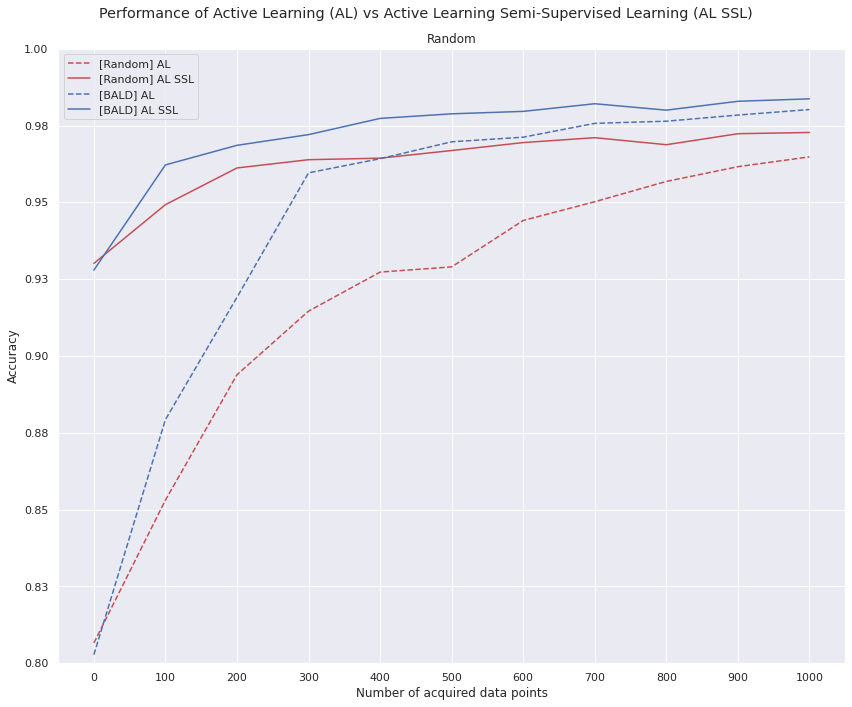

In [34]:
# Plot the SSL-AL Performance
# Plot
sns.set()


fig, (ax0) = plt.subplots(
                                    figsize=(12, 10))

# Set y axis format
ax0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 1001,100)
ax0.set_xticks(major_ticks)

x_ticks = np.arange(0, 1001,100)
ax0.plot(x_ticks, AL_perf_df['random'], '--r', label = '[Random] AL')
ax0.plot(x_ticks, SSL_perf_df['random'], '-r', label = '[Random] AL SSL')
ax0.plot(x_ticks, AL_perf_df['bald'], '--b', label = '[BALD] AL')
ax0.plot(x_ticks, SSL_perf_df['bald'], '-b', label = '[BALD] AL SSL')
ax0.set_title('Random')
ax0.set_ylim([0.8,1])
ax0.set_ylabel("Accuracy")
ax0.set_xlabel("Number of acquired data points")
ax0.legend()

fig.suptitle("Performance of Active Learning (AL) vs Active Learning Semi-Supervised Learning (AL SSL)")
plt.tight_layout()


# ORIGINAL DGM

In [11]:
from datautils import get_mnist, get_mnist_legacy

# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, validation = get_mnist_legacy(location="./", batch_size=64, labels_per_class=10)
alpha = 0.1 * len(unlabelled) / len(labelled)

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

model = DeepGenerativeModel([x_dim, y_dim, z_dim, h_dim])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))


/root/ucl/dissertation/./semi-supervised/models/vae.py:114: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


In [12]:
from itertools import cycle
from inference import SVI, ImportanceWeightedSampler

# You can use importance weighted samples [Burda, 2015] to get a better estimate
# on the log-likelihood.
sampler = ImportanceWeightedSampler(mc=1, iw=1)

if cuda: model = model.cuda()
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)


In [14]:
from torch.autograd import Variable

for epoch in range(10):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x), Variable(y), Variable(u)

        if cuda:
            # They need to be on the same device and be synchronized.
            x, y = x.cuda(device=0), y.cuda(device=0)
            u = u.cuda(device=0)

        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)
        
        # Regular cross entropy
        classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

        J_alpha = L - alpha * classication_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.data
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            x, y = Variable(x), Variable(y)

            if cuda:
                x, y = x.cuda(device=0), y.cuda(device=0)

            L = -elbo(x, y)
            U = -elbo(x)

            logits = model.classify(x)
            classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classication_loss + U

            total_loss += J_alpha.data

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(validation)
        print("[Validation]\t J_a: {:.4f}, accuracy: {:.4f}".format(total_loss / m, accuracy / m))


Epoch: 0
[Train]		 J_a: 269.18, accuracy: 1.00
[Validation]	 J_a: 347.3384, accuracy: 0.7481
Epoch: 1
[Train]		 J_a: 247.55, accuracy: 1.00
[Validation]	 J_a: 341.6221, accuracy: 0.7708


KeyboardInterrupt: 

EOFError: 

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalClassifier(nn.Module):
    def __init__(self):
        super(ConvolutionalClassifier, self).__init__()        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=4)

        size = int((28 - 3) + 1)//4
        size = int((size - 3) + 1)//4
                
        self.fc1 = nn.Linear(32*size**2, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        batch, *_ = x.size()
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(x.view(batch, -1))
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

classifier = ConvolutionalClassifier()
model.classifier = classifier.cuda()


In [35]:
df_AL = pd.read_csv('./saved_data/active_learning_performance_histories_100.csv')

In [36]:
df_AL['bald'].max()

0.9823

In [38]:
df_AL['random'].max()

0.967

In [41]:
df_SSL = pd.read_csv('./saved_data/SSL_test_accuracy_histories_100_w_AL_classifier_structure.csv')

In [44]:
df_SSL

,Unnamed: 0,random_test_accuracy,bald_test_accuracy
0,0,0.934614,0.966361
1,1,0.944964,0.973328
2,2,0.948149,0.976811
3,3,0.951732,0.978105
4,4,0.952329,0.978702
...,...,...,...
95,95,0.972830,0.984574
96,96,0.970740,0.985271
97,97,0.972233,0.984375
98,98,0.973229,0.986266


In [45]:
df_SSL['bald_test_accuracy'].max()

0.9862659573554992

In [46]:
df_SSL['random_test_accuracy'].max()

0.9735270738601683